In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import holidays
import logging
import warnings
from typing import List, Tuple, Optional, Union

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(name)s %(levelname)s %(message)s"
)

In [2]:
def generate_fourier_terms(
    index: pd.DatetimeIndex,
    K: int,
    period: int,
    origin: pd.Timestamp
) -> pd.DataFrame:
    """
    Generate K Fourier harmonics anchored at `origin`.
    Requires index.freq not None.
    """
    if index.freq is None:
        raise ValueError("generate_fourier_terms: index must have a fixed .freq")
    freqstr = index.freqstr
    base = freqstr.rstrip('S')  # 'MS'->'M', 'QS'->'Q'
    pi = index.to_period(base)
    origin_pi = origin.to_period(base)
    steps = pi.astype(int) - origin_pi.ordinal

    data = {}
    for k in range(1, K+1):
        angle = 2*np.pi*k*steps/period
        data[f"cos_{period}_{k}"] = np.cos(angle)
        data[f"sin_{period}_{k}"] = np.sin(angle)

    return pd.DataFrame(data, index=index)

In [3]:
def monthly_holiday_count(index: pd.DatetimeIndex, country_code: str) -> pd.DataFrame:
    """
    Count public holidays per month and broadcast to each timestamp.
    """
    start, end = index.min(), index.max()
    years = range(start.year, end.year+1)
    cal = holidays.CountryHoliday(country_code, years=years)

    periods = index.to_period('M')
    unique = periods.unique()
    counts = {per: sum(1 for d in cal if pd.Period(d,'M')==per)
              for per in unique}
    out = [counts[per] for per in periods]
    return pd.DataFrame({'holiday_count': out}, index=index)

In [4]:
class FadingMemoryARIMA:
    """
    ARIMA(p,d,q) via single fading‐memory Kalman ML:
      - P_pred ← (1/δ)·(F P Fᵀ) + G Q Gᵀ
      - δ ∈ (0,1)
      - auto‐ADF differencing up to max_d=2
      - exog: intercept, Fourier, holidays
    """
    def __init__(
        self,
        p: int,
        q: int,
        seasonal: Optional[Union[Tuple[int,int], List[Tuple[int,int]]]] = None,
        adf_threshold: float = 0.05,
        max_d: int = 2,
        include_intercept: bool = True
    ):
        if not isinstance(p,int) or p<0:
            raise ValueError("p must be nonnegative int")
        if not isinstance(q,int) or q<0:
            raise ValueError("q must be nonnegative int")
        self.p, self.q = p, q

        # Seasonal harmonics (K, period)
        if seasonal is None:
            self.seasonal: List[Tuple[int,int]] = []
        elif isinstance(seasonal, tuple) and len(seasonal)==2:
            self.seasonal = [seasonal]
        elif isinstance(seasonal,list) and all(isinstance(t,tuple) and len(t)==2 for t in seasonal):
            self.seasonal = seasonal
        else:
            raise ValueError("seasonal must be None, tuple(K,period), or list thereof")

        self.adf_threshold     = adf_threshold
        self.max_d             = max_d
        self.include_intercept = include_intercept

        # Placeholders
        self._origin     : pd.Timestamp = None
        self.d_          : int          = 0
        self.T0_         : int          = None
        self.params_ml_  : np.ndarray   = None
        self.nll_        : float        = None
        self.aic_        : float        = None
        self.bic_        : float        = None
        self.fitted_     : bool         = False

        # Data caches
        self.y_train_    : np.ndarray   = None
        self.y_diff_     : np.ndarray   = None
        self._initial_y  : np.ndarray   = None
        self._last_diff1 : float        = None

        self.X_train_    : np.ndarray   = None
        self.k_exog_     : int          = 0

        # State‐space caches
        self.x_last_     : np.ndarray   = None
        self.P_last_     : np.ndarray   = None

        self.logger = logging.getLogger(self.__class__.__name__)

    # 1) Stationarity & differencing
    def _adf_pvalue(self, y: np.ndarray) -> float:
        return adfuller(y, autolag="AIC")[1]

    def _difference(self, y: np.ndarray, order: int) -> np.ndarray:
        out = y.copy()
        for _ in range(order):
            out = np.diff(out)
        return out

    def _invert_diff(self, diffs: np.ndarray) -> np.ndarray:
        if self.d_ == 0:
            return diffs
        if self.d_ == 1:
            vals, last = [], self._initial_y[-1]
            for v in diffs:
                last += v
                vals.append(last)
            return np.array(vals)
        if self.d_ == 2:
            first_d, last_d1 = [], self._last_diff1
            for v in diffs:
                last_d1 += v
                first_d.append(last_d1)
            vals, last_y = [], self._initial_y[-1]
            for fd in first_d:
                last_y += fd
                vals.append(last_y)
            return np.array(vals)
        raise NotImplementedError("differencing inversion only supports d ≤ 2")

    # 2) Exogenous design
    def _build_exog(
        self,
        index: pd.DatetimeIndex,
        exog: Optional[np.ndarray]
    ) -> Optional[np.ndarray]:
        parts = []
        if self.include_intercept:
            parts.append(np.ones((len(index),1)))
        for K, period in self.seasonal:
            df_ft = generate_fourier_terms(index, K, period, self._origin)
            parts.append(df_ft.values)
        if exog is not None:
            arr = np.asarray(exog)
            if arr.shape[0] != len(index):
                raise ValueError("exog length mismatch")
            parts.append(arr)
        return np.hstack(parts) if parts else None

    # 3) ARMA→State‐Space companion form (Durbin & Koopman)
    def _build_arma_ss_matrices(
        self,
        phi: np.ndarray,
        theta: np.ndarray,
        sigma2: float
    ):
        """
        Innovations form with state‐dim m = max(p, q+1):
          x_{t+1} = F x_t + G ε_t,   y_t = H x_t + ε_t
        MA coefficients go into G.
        """
        m = max(self.p, self.q+1)
        F = np.zeros((m, m))
        # First row: AR coefficients
        if self.p > 0:
            F[0, :self.p] = phi
        # Companion shift for all lags
        for i in range(1, m):
            F[i, i-1] = 1.0

        # Noise‐input
        G = np.zeros((m, 1))
        G[0, 0] = 1.0                    # ε_t enters at top
        for j in range(self.q):
            if j+1 < m:
                G[j+1, 0] = theta[j]     # MA_j goes into second, third, ... rows

        # Measurement
        H = np.zeros((1, m))
        H[0, 0] = 1.0

        Q = np.array([[sigma2]])
        R = 0.0

        return F, G, H, Q, R

    def _run_kalman_filter(self, params, y, X, T0):
        idx    = 0
        sigma2 = params[idx]; idx += 1
        phi    = params[idx:idx+self.p];    idx += self.p
        theta  = params[idx:idx+self.q];    idx += self.q
        kx     = X.shape[1] if X is not None else 0
        beta   = params[idx:idx+kx];        idx += kx
        decay  = params[-1]

        F, G, H, Q, R = self._build_arma_ss_matrices(phi, theta, sigma2)
        T           = len(y)
        x           = np.zeros((F.shape[0],1))
        P           = np.eye(F.shape[0]) * 1e6
        innovs      = []

        for t in range(T):
            # Time update with forgetting
            x_pred = F @ x
            P_pred = (1.0/decay)*(F @ P @ F.T) + G @ Q @ G.T

            if t >= T0:
                ex    = (X[t-T0] @ beta) if kx>0 else 0.0
                yhat  = float((H @ x_pred)[0,0] + ex)
                err   = y[t] - yhat
                innovs.append(err)

                S = float((H @ P_pred @ H.T)[0,0] + R)
                S = max(S, 1e-8)
                K = P_pred @ H.T / S
                x = x_pred + K * err
                P = (np.eye(F.shape[0]) - K @ H) @ P_pred
            else:
                x, P = x_pred, P_pred

        return x, P, np.array(innovs)

    def _kalman_objective(self, params, y, X, T0):
        idx    = 0
        sigma2 = params[idx]; idx += 1
        if sigma2 <= 0:
            return 1e12
        phi    = params[idx:idx+self.p];    idx += self.p
        theta  = params[idx:idx+self.q];    idx += self.q
        kx     = X.shape[1] if X is not None else 0
        beta   = params[idx:idx+kx];        idx += kx
        decay  = params[-1]
        if not (1e-8 < decay < 1-1e-8):
            return 1e12

        F, G, H, Q, R = self._build_arma_ss_matrices(phi, theta, sigma2)
        x             = np.zeros((F.shape[0],1))
        P             = np.eye(F.shape[0]) * 1e6
        nll           = 0.0

        for t in range(len(y)):
            x_pred = F @ x
            P_pred = (1.0/decay)*(F @ P @ F.T) + G @ Q @ G.T

            if t >= T0:
                ex   = (X[t-T0] @ beta) if kx>0 else 0.0
                yhat = float((H @ x_pred)[0,0] + ex)
                err  = y[t] - yhat

                S = float((H @ P_pred @ H.T)[0,0] + R)
                S = max(S, 1e-8)

                nll += 0.5*(np.log(2*np.pi) + np.log(S) + err**2/S)

                K = P_pred @ H.T / S
                x = x_pred + K * err
                P = (np.eye(F.shape[0]) - K @ H) @ P_pred
            else:
                x, P = x_pred, P_pred

        return nll

    # 4) Fit
    def fit(
        self,
        y: Union[np.ndarray,pd.Series],
        exog: Optional[np.ndarray] = None,
        index: pd.DatetimeIndex = None,
        verbose: bool = False
    ):
        if index is None or index.freq is None:
            raise ValueError("A fixed‑frequency DateTimeIndex is required")

        self._origin = index.min()

        # 1) Differencing
        y_arr = np.asarray(y, float)
        d, pval = 0, self._adf_pvalue(y_arr)
        while pval>self.adf_threshold and d<self.max_d:
            y_arr = self._difference(y_arr,1)
            d += 1
            pval = self._adf_pvalue(y_arr)
        self.d_ = d
        if d==self.max_d and pval>self.adf_threshold:
            warnings.warn(f"Not stationary after {d} diffs (p={pval:.3f})")
        if verbose:
            self.logger.info(f"d={d}, ADF p={pval:.3f}")

        # Cache
        self.y_train_   = np.asarray(y, float)
        self._initial_y = self.y_train_.copy()
        if self.d_>=1:
            self._last_diff1 = np.diff(self.y_train_)[-1]
        self.y_diff_    = y_arr.copy()

        # 2) Exog
        T0   = max(self.p, self.q)
        self.T0_ = T0
        N_eff = len(self.y_diff_) - T0
        if N_eff<=0:
            raise ValueError("Not enough post‑burn‑in points")

        idx_eff  = index[d:][T0:]
        exog_eff = None if exog is None else exog[d+T0:]
        X        = self._build_exog(idx_eff, exog_eff)
        self.X_train_, self.k_exog_ = X, X.shape[1] if X is not None else 0

        # 3) Optimize
        init, bounds = [], []
        init.append(np.var(self.y_diff_)); bounds.append((1e-8,None))
        init += [0.0]*self.p;               bounds += [(-0.99,0.99)]*self.p
        init += [0.0]*self.q;               bounds += [(-0.99,0.99)]*self.q
        init += [0.0]*self.k_exog_;         bounds += [(None,None)]*self.k_exog_
        init.append(0.9);                   bounds.append((1e-8,1-1e-8))
        init = np.array(init)

        res = minimize(self._kalman_objective,
                       init, args=(self.y_diff_,X,T0),
                       method="L-BFGS-B", bounds=bounds)
        if not res.success:
            raise RuntimeError(f"Kalman ML failed: {res.message}")
        self.params_ml_, self.nll_ = res.x, res.fun

        # Warn
        decay = self.params_ml_[-1]
        if decay<1e-4:
            warnings.warn(f"δ≈{decay:.2e} ⇒ inflation=1/δ≈{1/decay:.0e}")

        # Cache final state
        x_fin, P_fin, innov = self._run_kalman_filter(
            self.params_ml_, self.y_diff_, X, T0
        )
        self.x_last_, self.P_last_, self.residuals_ = x_fin, P_fin, innov

        # 4) AIC/BIC
        k = 1 + self.p + self.q + self.k_exog_ + 1
        self.aic_ = 2*k + 2*self.nll_
        self.bic_ = np.log(N_eff)*k + 2*self.nll_

        self.fitted_ = True
        return self

    # 5) Forecast
    def forecast(
        self,
        steps: int,
        exog_future: Optional[np.ndarray] = None,
        index_future: pd.DatetimeIndex = None
    ) -> np.ndarray:
        if not self.fitted_:
            raise RuntimeError("Call fit() before forecast()")
        if index_future is None or index_future.freq is None:
            raise ValueError("forecast index must have fixed .freq")

        Xf = self._build_exog(index_future, exog_future)
        if Xf is not None and Xf.shape[1] != self.k_exog_:
            raise ValueError("exog_future has wrong number of columns")

        # Unpack
        idx    = 0
        sigma2 = self.params_ml_[idx]; idx+=1
        phi    = self.params_ml_[idx:idx+self.p];   idx+=self.p
        theta  = self.params_ml_[idx:idx+self.q];   idx+=self.q
        beta   = self.params_ml_[idx:idx+self.k_exog_]; idx+=self.k_exog_
        decay  = self.params_ml_[-1]

        F, G, H, Q, R = self._build_arma_ss_matrices(phi, theta, sigma2)
        x, P          = self.x_last_.copy(), self.P_last_.copy()
        out           = []

        for _ in range(steps):
            x = F @ x
            P = (1.0/decay)*(F @ P @ F.T) + G @ Q @ G.T
            ex = (Xf[_] @ beta) if self.k_exog_>0 else 0.0
            yhat = float((H @ x)[0,0] + ex)
            out.append(yhat)

        y_pred = np.array(out)
        return self._invert_diff(y_pred) if self.d_>0 else y_pred

In [5]:
# Load the data
URL = (
    "https://raw.githubusercontent.com/ejgao/"
    "Time-Series-Datasets/master/monthly-beer-production-in-austr.csv"
)
df = pd.read_csv(URL, parse_dates=["Month"], index_col="Month")
df.index.freq = "MS"
df.rename(columns={"Monthly beer production":"Beer"}, inplace=True)
df.head(10)

,Beer
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
1956-06-01,64.8
1956-07-01,70.1
1956-08-01,77.3
1956-09-01,79.5


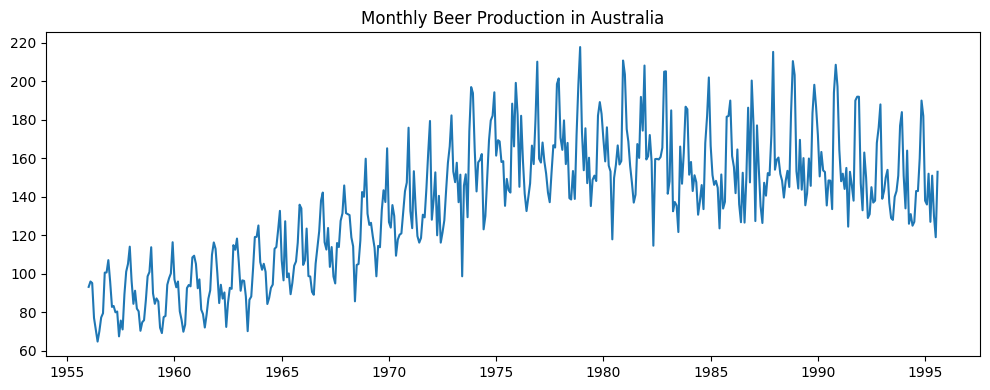

In [6]:
# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["Beer"])
plt.title("Monthly Beer Production in Australia")
plt.tight_layout()
plt.show()

In [7]:
# Log-transform
df["LogBeer"] = np.log(df["Beer"])

In [8]:
# Get holiday counts
hol_all = monthly_holiday_count(df.index, country_code="AU")

In [9]:
# Train/Test split
TEST = 24
train, test = df.iloc[:-TEST], df.iloc[-TEST:]
hol_tr, hol_te = hol_all.loc[train.index], hol_all.loc[test.index]

In [10]:
# Initialize and fit the model
fm_arima_model = FadingMemoryARIMA(
    p=2,
    q=1,
    seasonal=(2,12),
    adf_threshold=0.05,
    max_d=1,
    include_intercept=True
)

fm_arima_model.fit(
    y=train["LogBeer"].values,
    exog=hol_tr.values,
    index=train.index,
    verbose=True
)

In [11]:
# Forecast future values
fma_log_forecast = fm_arima_model.forecast(
    steps=TEST,
    exog_future=hol_te.values,
    index_future=test.index
)

fma_forecast = np.exp(fma_log_forecast)
actual = test["Beer"].values

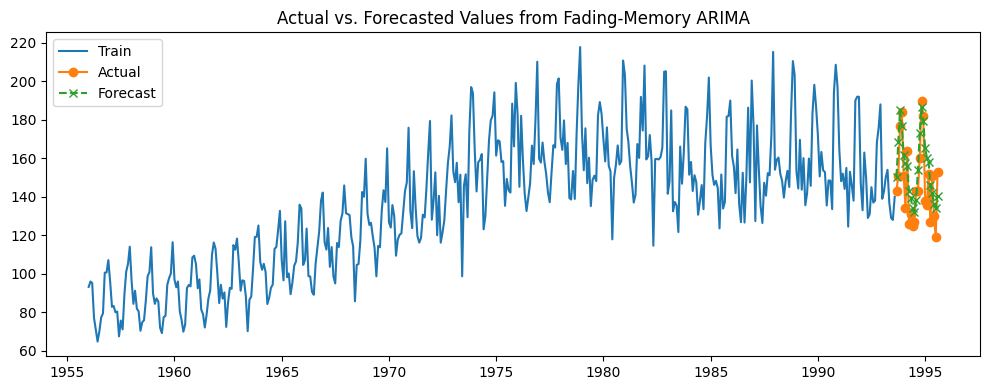

In [12]:
# Plot actual versus forecasted values
plt.figure(figsize=(10, 4))
plt.plot(train.index, train["Beer"], label="Train")
plt.plot(test.index, actual, 'o-', label="Actual")
plt.plot(test.index, fma_forecast, 'x--', label="Forecast")
plt.title("Actual vs. Forecasted Values from Fading-Memory ARIMA")
plt.legend()
plt.tight_layout()
plt.show()

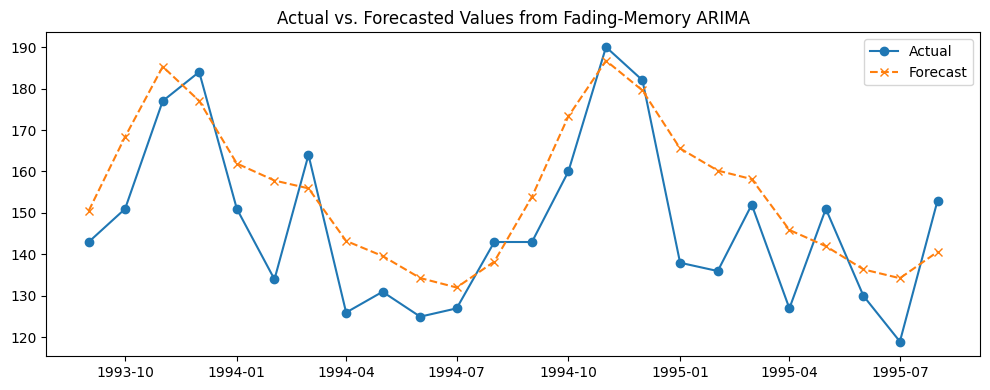

In [13]:
# Plot actual versus forecasted values
# Without training data
plt.figure(figsize=(10, 4))
plt.plot(test.index, actual, 'o-', label="Actual")
plt.plot(test.index, fma_forecast, 'x--', label="Forecast")
plt.title("Actual vs. Forecasted Values from Fading-Memory ARIMA")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# MAPE
fma_mape = np.mean(np.abs((actual - fma_forecast)/actual))*100
print(f"MAPE: {fma_mape:.2f}%")

# RMSE
fma_rmse = np.sqrt(np.mean((actual - fma_forecast)**2))
print(f"RMSE: {fma_rmse:.2f}")

# MAE
fma_mae = np.mean(np.abs(actual - fma_forecast))
print(f"MAE: {fma_mae:.2f}")

# Create metrics DataFrame
fma_metrics_df = pd.DataFrame(
    {"Scores": [fma_mape, fma_rmse, fma_mae]},
    index=["MAPE", "RMSE", "MAE"],
)
print("\nFading-Memory ARIMA Metrics:")
display(fma_metrics_df)

MAPE: 8.24%
RMSE: 13.38
MAE: 11.57

Fading-Memory ARIMA Metrics:


,Scores
MAPE,8.236296
RMSE,13.378312
MAE,11.571246


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Specify ARIMA order
order = (2, 1, 1)

# Intialize and fit statsmodels ARIMA
model = ARIMA(
    endog=train["LogBeer"],
    exog=hol_tr,
    order=order,
)
res = model.fit()

# Print the summary
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                LogBeer   No. Observations:                  452
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 287.560
Date:                Sat, 19 Apr 2025   AIC                           -565.119
Time:                        20:11:18   BIC                           -544.562
Sample:                    01-01-1956   HQIC                          -557.018
                         - 08-01-1993                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
holiday_count     0.0186      0.006      3.135      0.002       0.007       0.030
ar.L1            -1.0509      0.104    -10.149      0.000      -1.254      -0.848
ar.L2            -0.3315      0.047     

In [16]:
# Forecast TEST steps ahead
pred_res = res.get_forecast(
    steps=TEST,
    exog=hol_te
)

# Extract the mean forecast in log‑space
arima_log_forecast = pred_res.predicted_mean

# Back-transform to original scale
arima_forecast = np.exp(arima_log_forecast)

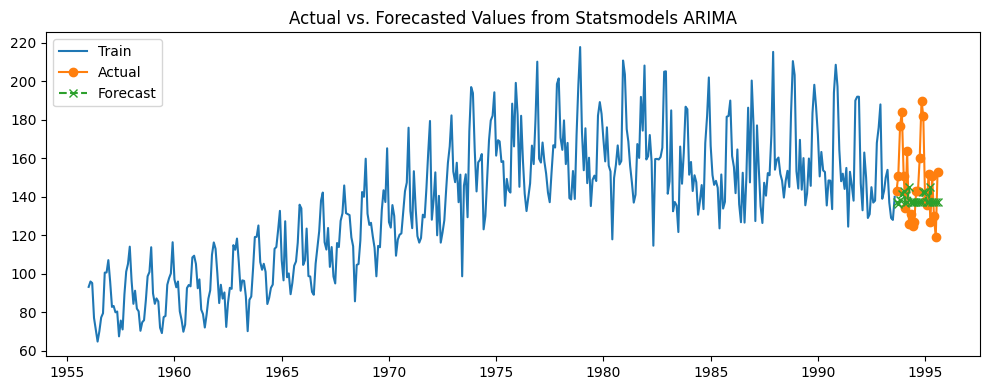

In [17]:
# Plot actual versus forecasted values
plt.figure(figsize=(10, 4))
plt.plot(train.index, train["Beer"], label="Train")
plt.plot(test.index, actual, 'o-', label="Actual")
plt.plot(test.index, arima_forecast, 'x--', label="Forecast")
plt.title("Actual vs. Forecasted Values from Statsmodels ARIMA")
plt.legend()
plt.tight_layout()
plt.show()

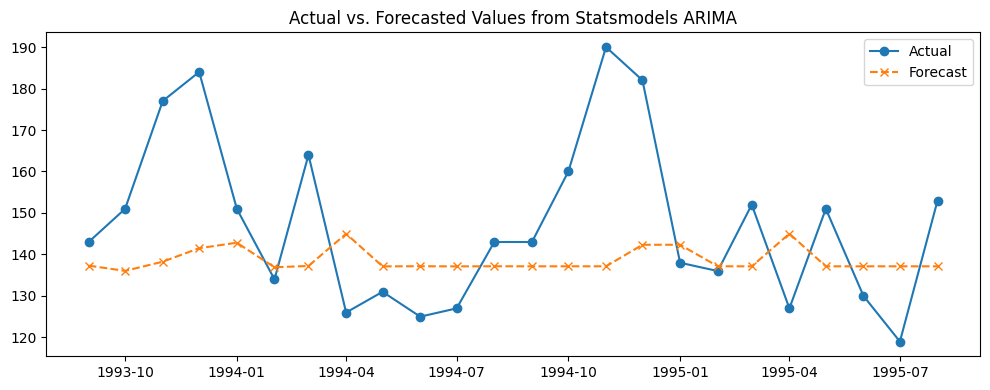

In [18]:
# Plot actual versus forecasted values
# Without training data
plt.figure(figsize=(10, 4))
plt.plot(test.index, actual, 'o-', label="Actual")
plt.plot(test.index, arima_forecast, 'x--', label="Forecast")
plt.title("Actual vs. Forecasted Values from Statsmodels ARIMA")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# MAPE
arima_mape = np.mean(np.abs((actual - arima_forecast)/actual))*100
print(f"MAPE: {arima_mape:.2f}%")

# RMSE
arima_rmse = np.sqrt(np.mean((actual - arima_forecast)**2))
print(f"RMSE: {arima_rmse:.2f}")

# MAE
arima_mae = np.mean(np.abs(actual - arima_forecast))
print(f"MAE: {arima_mae:.2f}")

# Create metrics DataFrame
arima_metrics_df = pd.DataFrame(
    {"Scores": [arima_mape, arima_rmse, arima_mae]},
    index=["MAPE", "RMSE", "MAE"],
)
print("\nStatsmodels ARIMA Metrics:")
display(arima_metrics_df)

MAPE: 10.86%
RMSE: 21.75
MAE: 16.98

Statsmodels ARIMA Metrics:


,Scores
MAPE,10.855952
RMSE,21.747847
MAE,16.983118


In [20]:
# Rename the 'Scores' column in each DataFrame to the model name
fma_named = fma_metrics_df.rename(columns={"Scores": "Fading‑Memory ARIMA"})
arima_named = arima_metrics_df.rename(columns={"Scores": "Statsmodels ARIMA"})

# Join on the index (metric names)
combined_metrics = pd.concat([fma_named, arima_named], axis=1)

print("Comparison of Model Results:")
display(combined_metrics)

Comparison of Model Results:


,Fading‑Memory ARIMA,Statsmodels ARIMA
MAPE,8.236296,10.855952
RMSE,13.378312,21.747847
MAE,11.571246,16.983118


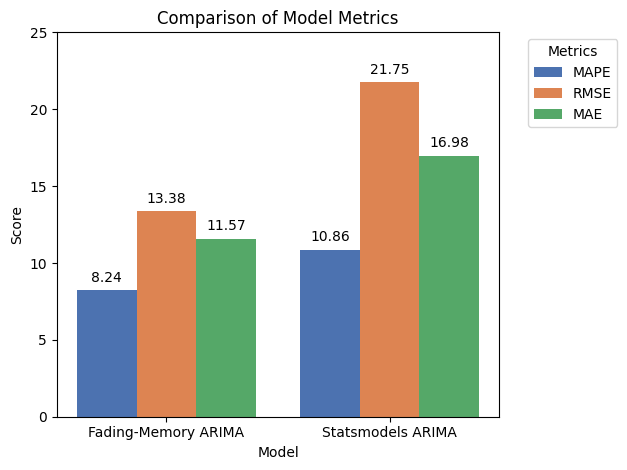

In [21]:
# Prepare bar locations
models = combined_metrics.columns.tolist()
metrics = combined_metrics.index.tolist()
x = np.arange(len(models))
width = 0.8 / len(metrics)  # total group width = 0.8

# Define a custom palette
colors = ['#4C72B0', '#DD8452', '#55A868']

fig, ax = plt.subplots()

# Draw each metric's bars in its custom color
for i, metric in enumerate(metrics):
    vals = combined_metrics.loc[metric].values
    ax.bar(x + i * width, vals, width, label=metric, color=colors[i])

# Center the x‐ticks and give plenty of headroom
ax.set_xticks(x + width*(len(metrics)-1)/2)
ax.set_xticklabels(models)
max_val = combined_metrics.values.max()
ax.set_ylim(0, max_val * 1.15)   # 15% extra above highest bar

# Labels, title, and a legend outside the plot
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Metrics')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars with metric values
for bar in ax.patches:
    h = bar.get_height()
    if h > 0:
        ax.annotate(
            f'{h:.2f}',
            xy=(bar.get_x() + bar.get_width()/2, h),
            xytext=(0, 4),
            textcoords='offset points',
            ha='center',
            va='bottom'
        )

plt.tight_layout()
plt.show()